In [1]:
import math
from mpmath import mp, fp
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Helper class to invoke a CXX compiler and link against result
import atexit
import ctypes
import os
import shlex
import sys
import tempfile

# This is the C compiler command line, which is used to generate object files.
CMDLINE_C_TO_OBJ = '{compiler} -fPIC -c -O3 -o {output} {input}'

# This is the C compiler command line, which is used to generate C shared
# libraries.
CMDLINE_OBJ_TO_SO = '{compiler} -shared -o {output} {input} {libraries}'

class C:
    r"""
    Compiles and loads C code into a Python program, optionally linking in other
    shared libraries along with the loaded code.
    >>> hello_world = C('''
    ... #include <stdio.h>
    ... 
    ... void say_hello() {
    ...     printf("Hello, World\n");
    ... }
    ... ''')
    ...
    >>> hello_world['say_hello']()
    Hello, World
    """
    def __init__(self, compiler, code, *shared_libs):
        self.library = None
        self._compile(compiler, code, shared_libs)

    def _compile(self, compiler, code, libs):
        """
        Compiles a hunk of C code into a shared library, and links it into the
        current program. Note that all libraries given (they are assumed to be
        shared libraries) are also linked into the shared library, and thus
        loaded into the current program as well.
        """
        # Dump the C code into a temporary file, and run the compiler to make
        # an object file
        with tempfile.NamedTemporaryFile(mode='w', prefix='PYC', suffix='.cpp', delete=False) as temp_c_file:
            temp_c_file_name = temp_c_file.name

            temp_c_file.write(code)
            temp_c_file.flush()

        obj_file_name = tempfile.mktemp(prefix='PYC', suffix='.o')
        os.system(CMDLINE_C_TO_OBJ.format(compiler=compiler, 
            output=shlex.quote(obj_file_name), 
            input=shlex.quote(temp_c_file_name)))
        #os.remove(temp_c_file_name)

        # Run the compiler one more time to generate a shared library
        so_file_name = tempfile.mktemp(prefix='PYC', suffix='.so')
        library_cmd = ' '.join('-l' + lib for lib in libs)
        os.system(CMDLINE_OBJ_TO_SO.format(compiler=compiler,
            output=shlex.quote(so_file_name),
            input=shlex.quote(obj_file_name),
            libraries=library_cmd))
        #os.remove(obj_file_name)

        # Punt to ctypes so that we can get a loadable library from whatever
        # we just built
        self.library = ctypes.cdll.LoadLibrary(so_file_name)
        
        # Ensure that we clean up the temp files when the program is exiting
        atexit.register(lambda: os.remove(so_file_name))
            
    def __getitem__(self, func):
        if self.library is None:
            assert False, "How did C.__getitem__ get called without loading the library?"

        return getattr(self.library, func)
    


In [70]:
# Prepare high precision results
R       = 15 # target radius
rad_min = 0.9
rad_max = 1.000
rad_res = 30 # number of radial steps (resolution of experiments)
mp.dps  = 50 # precision of lib

def uniformSample(R, frac):
    return math.acosh(frac * (math.cosh(R) - 1.0) + 1.0)

def distanceBelowR(r1, phi1, r2, phi2, R):
    tmp = mp.cosh(r1 - r2) + (1.0 - mp.cos(phi1 - phi2)) * mp.sinh(r1) * mp.sinh(r2)
    if (tmp < 1.0): tmp = 1.0
    return mp.acosh(tmp) < R

def relError(cor, approx):
    return (cor - mp.convert(approx)) / cor

def largestBelow(is_below, r1, phi1, r2, R):
    r1, r2, phi1, R = (mp.convert(x) for x in [r1, r2, phi1, R])
    left = phi1
    right = 2.0 * mp.pi
    
    while True:
        mid = (left * 0.5) + (right * 0.5)
        if (mid == left) or (mid == right):
            return mid
        
        if (is_below(r1, phi1, r2, mid, R)):
            left = mid
        else:
            right = mid

def getFrac(i):
    return rad_min + (rad_max - rad_min) * i / rad_res
        
jobs = []
for r1i, r1 in ((x, uniformSample(R, getFrac(x))) for x in range(1, rad_res)):
    for r2i, r2 in ((x, uniformSample(R, getFrac(x))) for x in range(r1i, rad_res)):
        cor = largestBelow(distanceBelowR, r1, 0.0, r2, R)
        jobs.append((r1i, r1, r2i, r2, cor))

In [56]:
# Implement C++ counter-parts
c_lib = C('g++', '''
#include <cmath>


#define DEF_TEST(X)                                                                     \\
    template <typename T> T dist_impl_ ## X(T r1, T phi1, T r2, T phi2, T R);           \\
                                                                                        \\
    extern "C" {                                                                        \\
        double dist_ ## X(double r1, double phi1, double r2, double phi2, double R) {   \\
            return dist_impl_ ## X<double>(r1, phi1, r2, phi2, R);}                     \\
                                                                                        \\
        long double dist_ld_ ## X(long double r1, long double phi1,                     \\
                                  long double r2, long double phi2, long double R) {    \\
            return dist_impl_ ## X<long double>(r1, phi1, r2, phi2, R);}                \\
                                                                                        \\
        double test_ ## X(double r1, double phi1, double r2, double R) {                \\
            return binSearchPhi<double>(phi1, [=] (double x) {                          \\
                return dist_ ## X(r1, phi1, r2, x, R);                                  \\
            });                                                                         \\
        }                                                                               \\
                                                                                        \\
        long double test_ld_ ## X(long double r1, long double phi1,                     \\
                                  long double r2, long double R) {                      \\
            return binSearchPhi<long double>(phi1, [=] (long  double x) {               \\
                return dist_ld_ ## X(r1, phi1, r2, x, R);                               \\
            });                                                                         \\
        }                                                                               \\
    };                                                                                  \\
                                                                                        \\
    template <typename T> T dist_impl_ ## X(T r1, T phi1, T r2, T phi2, T R)

template <typename T, typename CB>
T binSearchPhi(T phi1, CB cb) {
    T left = phi1;
    T right = 2*3.14159265358979323846264338;
    T mid;

// binary search
    while(true) {
        mid = (left + right) * 0.5;
        if (mid == left || mid == right)
            break;

        if (cb(mid))
            left = mid;
        else
            right = mid;
    }

// linear improvement
    while(true) {
        T next = std::nextafter(mid, T{10.0});
        if (!cb(next))
            return mid;
        mid = next;
    }
}


DEF_TEST(acosh) {
    T tmp = cosh(r1 - r2) + (T{1.} - cos(phi1 - phi2)) * sinh(r1) * sinh(r2);
    if (tmp < 1.0) tmp = 1.0;
    return acosh(tmp) < R;
}

DEF_TEST(coshR) {
    T tmp = cosh(r1 - r2) + (T{1.} - cos(phi1 - phi2)) * sinh(r1) * sinh(r2);
    return tmp < cosh(R);
}

DEF_TEST(pcomp) {
    return cos(phi1) * cos(phi2) + sin(phi1) * sin(phi2) > 
        (cosh(r1)/sinh(r1)) * (cosh(r2)/sinh(r2)) - cosh(R) * (1.0 / sinh(r1)) * (1.0 / sinh(r2));
}

DEF_TEST(cos) {
    return cos(phi1 - phi2) > (cosh(r1)/sinh(r1)) * (cosh(r2)/sinh(r2)) - cosh(R) * (1.0 / sinh(r1)) * (1.0 / sinh(r2));
}

DEF_TEST(icos) {
    T is1 = T{1.0} / sinh(r1);
    T is2 = T{1.0} / sinh(r2);

    return cos(phi1 - phi2) > (cosh(r1)*is1) * (cosh(r2)*is2) - cosh(R) * is1 * is2;
}

DEF_TEST(icosh) {
    T is1 = 1.0 / sinh(r1);
    T is2 = 1.0 / sinh(r2);

    return cos(phi1 - phi2) > (cosh(r1) * cosh(r2) - cosh(R)) * is1 * is2;
}

''')

approx_keys = ["acosh", "coshR", "pcomp", "cos", "icos", "icosh"]
for key in approx_keys:
    fu = c_lib["test_" + key]
    fu.argtypes = [ctypes.c_double] * 4
    fu.restype = ctypes.c_double 

    fu = c_lib["test_ld_" + key]
    fu.argtypes = [ctypes.c_longdouble] * 4
    fu.restype = ctypes.c_longdouble 

    
approx_algos = [(x, c_lib["test_" + x]) for x in approx_keys] + [("ld_" + x, c_lib["test_ld_" + x]) for x in approx_keys]


In [76]:
# Benchmark CXX functions
def bits_agreeing(correct, approx):
    return float(mp.mag(correct) - mp.log(mp.fabs(correct - approx), 2))

results = []
for r1i, r1, r2i, r2, cor in jobs:
    for key, approx in approx_algos:
        approx_res = approx(r1, 0.0, r2, R)
        rerr = relError(cor, approx_res)
        results.append({"algo": key,
                        "r1i": r1i, "r1": r1,
                        "r2i": r2i, "r2": r2,
                        "cor": cor,
                        "approx": approx_res,
                        "rerr": mp.fabs(rerr),
                        "rerr_s": rerr,
                        "prec": bits_agreeing(cor, approx_res)
                       })
        
data = pd.DataFrame(results)
maxerr = data.rerr.max()
data["nerr"] = [float(x) for x in data.rerr / maxerr]

# Print-out maximal normalized error
print(data.groupby("algo").prec.min().sort_values())
print(data.groupby("algo").prec.median().sort_values())
print(data.groupby("algo").prec.max().sort_values())

   

algo
icos        31.362943
cos         31.554601
ld_cos      31.554601
ld_pcomp    31.554601
pcomp       31.554601
icosh       31.582327
ld_icos     31.783910
ld_icosh    31.783910
acosh       35.191484
coshR       35.191484
ld_acosh    35.191484
ld_coshR    35.191484
Name: prec, dtype: float64
algo
icosh       33.892240
icos        33.908835
cos         33.916502
ld_cos      33.916502
ld_pcomp    33.916502
pcomp       33.916502
ld_icosh    34.094904
ld_icos     34.203480
acosh       36.271022
coshR       36.271022
ld_acosh    36.271022
ld_coshR    36.271022
Name: prec, dtype: float64
algo
ld_icosh    41.670313
icosh       42.114268
cos         42.785526
icos        42.785526
ld_cos      42.785526
ld_pcomp    42.785526
pcomp       42.785526
ld_icos     43.539933
acosh       44.298596
coshR       44.298596
ld_acosh    44.298596
ld_coshR    44.298596
Name: prec, dtype: float64


In [60]:
?mp.log

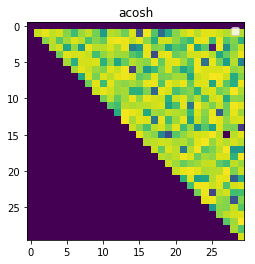

33620.58963023192601443834020564361937279289481115 ppm
130.29756840050422139677478488685986705058739987993 ppm


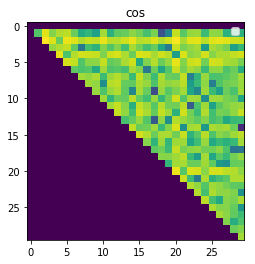

168541.48385484986737418865128621794810228004372611 ppm
372.48600015426217879091134306400609437347996453087 ppm


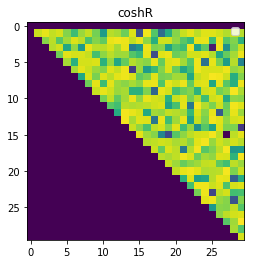

33620.58963023192601443834020564361937279289481115 ppm
130.29756840050422139677478488685986705058739987993 ppm


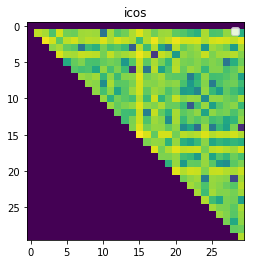

171959.00916935481162510242402567675091861252533049 ppm
372.48600015426217879091134306400609437347996453087 ppm


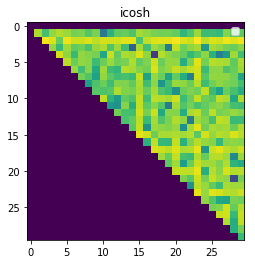

171180.19780054479919464845318247459977685518595201 ppm
570.82117495923541617277816703107706295850227505165 ppm


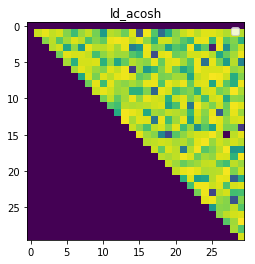

33620.58963023192601443834020564361937279289481115 ppm
130.29756840050422139677478488685986705058739987993 ppm


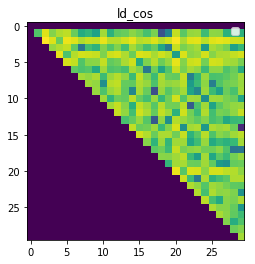

168541.48385484986737418865128621794810228004372611 ppm
372.48600015426217879091134306400609437347996453087 ppm


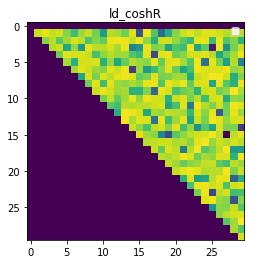

33620.58963023192601443834020564361937279289481115 ppm
130.29756840050422139677478488685986705058739987993 ppm


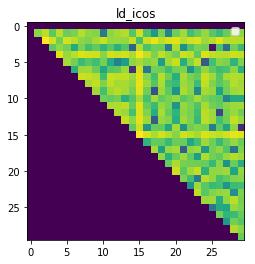

138916.65608916460479718335843974103030769320767936 ppm
215.0346277936229132875949076900303358851475982612 ppm


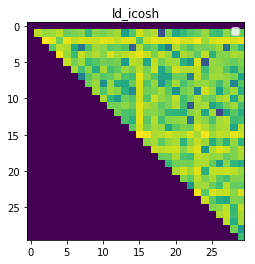

151611.3106380176902117825781015085783086335091633 ppm
800.01482546361912571191254515657050915981627611746 ppm


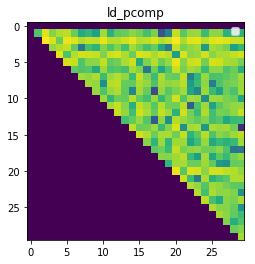

168541.48385484986737418865128621794810228004372611 ppm
372.48600015426217879091134306400609437347996453087 ppm


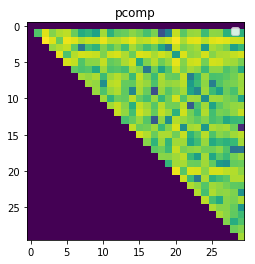

168541.48385484986737418865128621794810228004372611 ppm
372.48600015426217879091134306400609437347996453087 ppm


In [72]:
max_prec = data.prec.max()

for algo, view in data.groupby("algo"):
    mat = np.zeros((data.r1i.max()+1, data.r2i.max()+1))
    
    for _, row in view.iterrows():
        mat[row.r1i, row.r2i] = max_prec - row.prec

    plt.title(algo)
    plt.imshow(mat)
    plt.legend()
    plt.show()
    
    print(np.median(view.rerr) / maxerr * 1e6, "ppm")
    print(np.min(view.rerr) / maxerr * 1e6, "ppm")

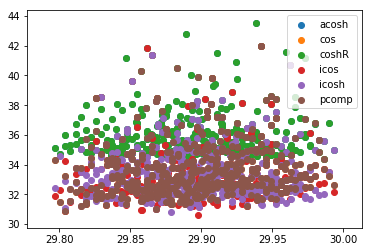

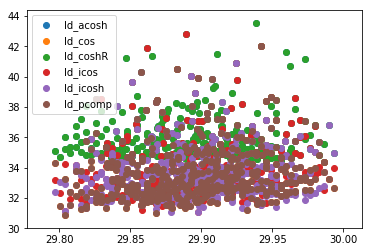

In [75]:
for ld in [False, True]:
    for algo, view in data.groupby("algo"):
        if algo.startswith("ld_") == ld:
            plt.scatter(view.r1 + view.r2, view.prec, label=algo)

    plt.legend()
    plt.show()
    

In [58]:
results

[{'algo': 'acosh',
  'r1i': 1,
  'r1': 11.598820360430919,
  'r2i': 1,
  'r2': 11.598820360430919,
  'cor': mpf('0.033185986107568205863487679081037180304157545352415703'),
  'approx': 0.033185986107566706,
  'rerr': mpf('0.000000000000045189854786200134675290938609781772764385704595449946'),
  'rerr_s': mpf('0.000000000000045189854786200134675290938609781772764385704595449946')},
 {'algo': 'coshR',
  'r1i': 1,
  'r1': 11.598820360430919,
  'r2i': 1,
  'r2': 11.598820360430919,
  'cor': mpf('0.033185986107568205863487679081037180304157545352415703'),
  'approx': 0.033185986107566706,
  'rerr': mpf('0.000000000000045189854786200134675290938609781772764385704595449946'),
  'rerr_s': mpf('0.000000000000045189854786200134675290938609781772764385704595449946')},
 {'algo': 'pcomp',
  'r1i': 1,
  'r1': 11.598820360430919,
  'r2i': 1,
  'r2': 11.598820360430919,
  'cor': mpf('0.033185986107568205863487679081037180304157545352415703'),
  'approx': 0.03318598610756336,
  'rerr': mpf('0.000000000